In [1]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SBX_SECRET_KEY = os.getenv('PLAID_SBX_SECRET_KEY')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [4]:
INSTITUTION_ID = "ins_109508"

In [5]:
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SBX_SECRET_KEY, public_key=PLAID_PUBLIC_KEY, environment='sandbox')

### 2. Generate a public token

In [6]:
create_tkn_response = client.Sandbox.public_token.create(INSTITUTION_ID, ['transactions','income','assets'])

### 3. Exchange the public token for an access token

In [7]:
exchange_response = client.Item.public_token.exchange(create_tkn_response['public_token'])

### 4. Fetch Accounts

In [8]:
access_token = exchange_response['access_token']

---

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [9]:
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-90))
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now()) 
transactions_response = client.Transactions.get(access_token, start_date, end_date)
# transactions_response

### 2. Print the categories for each transaction

In [10]:
categories=[]
for transactions in transactions_response['transactions']:
    categories.append(transactions['category'][0])
print(categories)

['Payment', 'Travel', 'Transfer', 'Transfer', 'Recreation', 'Travel', 'Food and Drink', 'Food and Drink', 'Food and Drink', 'Transfer', 'Travel', 'Travel', 'Food and Drink', 'Payment', 'Food and Drink', 'Shops']


### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [11]:
# Create empty lists for data we are interested in, move through the transactions dictionary inside of the transactions response dictionary.
# put each list into a new dictionary
dictionary={}
Dates=[]
Amount=[]
Name=[]
for transactions in transactions_response['transactions']:
        Dates.append(transactions['date'])
        Amount.append(transactions['amount'])
        Name.append(transactions['name'])
dictionary = {'Dates':Dates,
        'Name':Name,
       'Amount':Amount,
       'Category':categories}

In [12]:
# Turn that dictionary into a dataframe.
transactions_df=pd.DataFrame(data=dictionary)

### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [13]:
transactions_df["Dates"]=pd.to_datetime(transactions_df["Dates"])
transactions_df.set_index(transactions_df["Dates"],inplace=True)

In [14]:
transactions_df.drop(columns=['Dates'],inplace=True)

In [15]:
transactions_df["Amount"] = transactions_df["Amount"].astype('float')
# transactions_df

---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [16]:
# YOUR CODE HERE

---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

In [17]:
table_ctgry=pd.pivot_table(transactions_df, index='Dates',columns='Category')
table_ctgry

Amount                                           
Category   Food and Drink Payment Recreation  Shops Transfer  Travel
Dates                                                               
2019-12-26        500.000  2078.5        NaN  500.0      NaN     NaN
2019-12-27        500.000     NaN        NaN    NaN      NaN     NaN
2019-12-30            NaN     NaN        NaN    NaN      NaN    6.33
2020-01-01            NaN     NaN        NaN    NaN      NaN  500.00
2020-01-11            NaN     NaN        NaN    NaN    -4.22     NaN
2020-01-12         89.400     NaN        NaN    NaN      NaN     NaN
2020-01-13          8.165     NaN        NaN    NaN      NaN     NaN
2020-01-14            NaN     NaN       78.5    NaN      NaN -500.00
2020-01-15            NaN     NaN        NaN    NaN  3425.00     NaN
2020-01-16            NaN    25.0        NaN    NaN      NaN    5.40

### Calculate the expenses per category

In [18]:
ctgry_sums=pd.DataFrame(data=table_ctgry.sum(axis=0))
ctgry_sums.reset_index(level='Category',inplace=True)
ctgry_sums

,Category,0
Amount,Food and Drink,1097.565
Amount,Payment,2103.500
Amount,Recreation,78.500
Amount,Shops,500.000
Amount,Transfer,3420.780
Amount,Travel,11.730


In [19]:
print(ctgry_sums['Category'])

Amount    Food and Drink
Amount           Payment
Amount        Recreation
Amount             Shops
Amount          Transfer
Amount            Travel
Name: Category, dtype: object


Text(0.5, 1.0, 'Spending Categories by Amount')

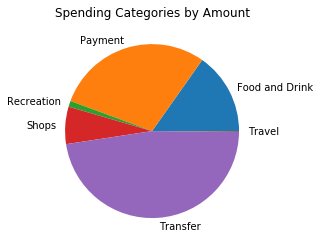

In [20]:
ctgry_spending=plt.pie(ctgry_sums[0],labels=ctgry_sums['Category'])
ctgry_spending=plt.title('Spending Categories by Amount')
ctgry_spending

In [21]:
ctgry_qty=pd.DataFrame(data=table_ctgry.count(axis=0))
ctgry_qty.reset_index(level='Category',inplace=True)
ctgry_qty

,Category,0
Amount,Food and Drink,4
Amount,Payment,2
Amount,Recreation,1
Amount,Shops,1
Amount,Transfer,2
Amount,Travel,4


Text(0.5, 1.0, 'Spending Categories by Quantity')

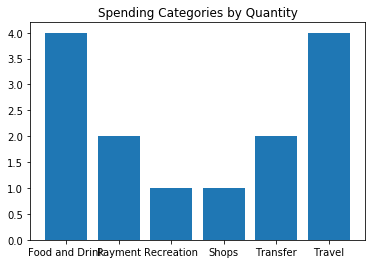

In [22]:
ctgry_qty_bar = plt.bar(ctgry_qty['Category'],height=ctgry_qty[0],width=0.8)
ctgry_qty_bar = plt.title('Spending Categories by Quantity')
ctgry_qty_bar

### Calculate the expenses per month

In [23]:
ctgry_month1=table_ctgry.groupby(pd.Grouper(freq='M')).sum()
ctgry_month=ctgry_month1['Amount']
ctgry_month

Category,Food and Drink,Payment,Recreation,Shops,Transfer,Travel
Dates,,,,,,
2019-12-31,1000.000,2078.5,0.0,500.0,0.00,6.33
2020-01-31,97.565,25.0,78.5,0.0,3420.78,5.40


In [24]:
ctgry_month=ctgry_month.drop(columns='Payment')
print(ctgry_month)

Category    Food and Drink  Recreation  Shops  Transfer  Travel
Dates                                                          
2019-12-31        1000.000         0.0  500.0      0.00    6.33
2020-01-31          97.565        78.5    0.0   3420.78    5.40


In [25]:
ctgry_month['Total']=ctgry_month.sum(axis=1)
ctgry_month

Category,Food and Drink,Recreation,Shops,Transfer,Travel,Total
Dates,,,,,,
2019-12-31,1000.000,0.0,500.0,0.00,6.33,1506.330
2020-01-31,97.565,78.5,0.0,3420.78,5.40,3602.245


In [50]:
ctgry_totals=pd.DataFrame(ctgry_month['Total'])
ctgry_totals.reset_index(inplace=True)
ctgry_totals

,Dates,Total
0,2019-12-31,1506.330
1,2020-01-31,3602.245


In [51]:
ctgry_totals.plot.bar(x=ctgry_totals['Dates'],y=ctgry_totals['Total'])

KeyError: "None of [DatetimeIndex(['2019-12-31', '2020-01-31'], dtype='datetime64[ns]', freq=None)] are in the [columns]"

Text(0.5, 1.0, 'Spending Categories by Quantity')

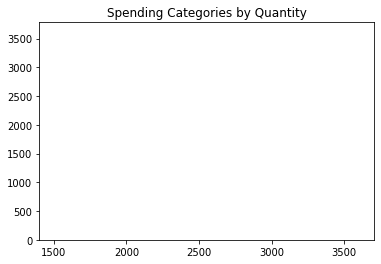

In [52]:
ctgry_month_bar = plt.bar(ctgry_totals['Total'],height=ctgry_totals['Total'],width=0.8)
ctgry_month_bar = plt.title('Spending Categories by Quantity')
ctgry_month_bar